In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score, mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import sample_data as sd
import matplotlib.pyplot as plt
rs = 1234

### Import and load dataset/train test split

In [ ]:
df = pd.read_csv("C:/Users/laxjo/Downloads/digital_marketing_campaign_dataset_cleaned.csv")
df.shape

(7851, 21)

In [ ]:
import pickle

# Load the train/test splits from pickle files
with open("C:/Users/laxjo/Downloads/MISY331/331FinalProject/X_train.p", 'rb') as f:
    X_train = pickle.load(f)

with open("C:/Users/laxjo/Downloads/MISY331/331FinalProject/X_test.p", 'rb') as f:
    X_test = pickle.load(f)

with open("C:/Users/laxjo/Downloads/MISY331/331FinalProject/y_train.p", 'rb') as f:
    y_train = pickle.load(f)

with open("C:/Users/laxjo/Downloads/MISY331/331FinalProject/y_test.p", 'rb') as f:
    y_test = pickle.load(f)

In [ ]:
X_train.head()

,Age,Income,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,...,PreviousPurchases,LoyaltyPoints,is _Male,channel _PPC,channel _Referral,channel _SEO,channel _Social Media,type _Consideration,type _Conversion,type _Retention
2759,30,58015,1098.170827,0.107886,0.103538,24,3.598307,11.166441,57,3,...,7,4025,0,0,0,0,1,0,0,1
4453,60,131257,1110.998883,0.225685,0.023993,2,7.394787,6.320947,76,17,...,3,4660,1,0,1,0,0,0,0,0
4976,43,94693,9585.417151,0.154004,0.054993,15,4.970331,5.648482,73,15,...,3,3508,0,1,0,0,0,0,0,0
7630,49,67408,4676.118311,0.084945,0.012766,25,8.212897,12.604250,60,3,...,4,2974,0,0,0,0,1,0,0,0
7795,50,72788,2356.454779,0.209118,0.180690,38,6.520577,0.990825,21,2,...,6,2067,1,0,0,0,1,1,0,0


### Scale data

In [ ]:
scaler_x = StandardScaler()

## Unfortunately, sklearn's scaler's don't play nice with pandas data frames, so we'll need to
## Re-assign the index and column names manually
X_train2 = pd.DataFrame(scaler_x.fit_transform(X_train), columns = X_train.columns.tolist(),
                        index = X_train.index)
X_test2 = pd.DataFrame(scaler_x.transform(X_test), columns = X_test.columns.tolist(),
                       index = X_test.index)

<Axes: >

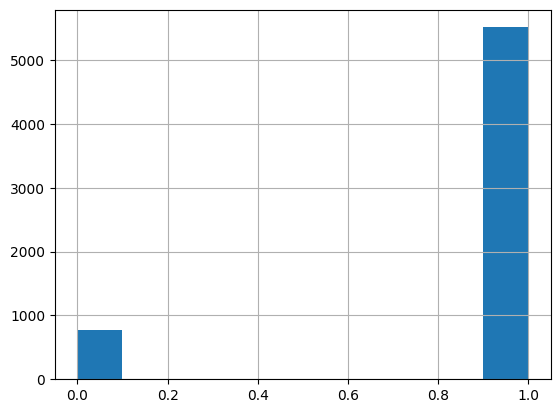

In [ ]:
y_train.hist()

### Clustering

In [ ]:
## But What Variables should we cluster on that will help us identify Low, Medium, and High Risk loans?
## Risk of what?
adjust = {
    0: -2,
    1: 2
}

X_train2['Converted'] = y_train.replace(adjust)
X_test2['Converted'] = y_test.replace(adjust)

In [ ]:
## We know we want 3 clusters: converted and did not convert
kmns = KMeans(n_clusters = 2,
              max_iter = 5000,
              tol=0.001,
              init = 'random',
              n_init= 'auto',
              random_state = rs)

kmns = kmns.fit(X_train2)

## Generate Predictions
y_train_hat = kmns.predict(X_train2)
y_test_hat = kmns.predict(X_test2)

## The total, negative inertia of the given X sets
kmns.score(X_train2), kmns.score(X_test2)

(-130998.93729909172, -32696.71480417367)

<Axes: xlabel='Cluster', ylabel='Count'>

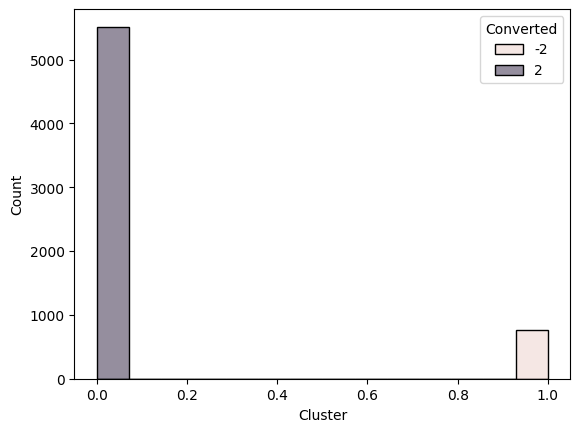

In [ ]:
## Training Histogram
X_train3 = X_train2.copy()
X_train3['Cluster'] = y_train_hat

sns.histplot(data = X_train3,
             x = 'Cluster', hue = 'Converted')

<Axes: xlabel='Cluster', ylabel='Count'>

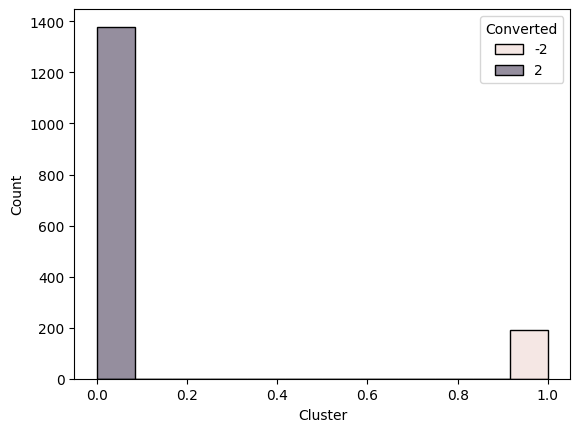

In [ ]:
## Test Histogram
X_test3 = X_test2.copy()
X_test3['Cluster'] = y_test_hat

sns.histplot(data = X_test3, x = 'Cluster', hue = 'Converted')

In [ ]:
## Using the new cluster labels,
## we can train a classifier ...

## data organization
X_train4 = X_train3.copy()
X_test4 = X_test3.copy()

label = {
    0: 1, # Converted
    1: 0, # Did not convert
}
y_train4 = X_train4['Cluster'].replace(label)
y_test4 = X_test4['Cluster'].replace(label)

X_train4 = X_train4.drop(columns = ['Cluster', 'Converted'])
X_test4 = X_test4.drop(columns = ['Cluster', 'Converted'])